In [96]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Cluster Running Workouts

In [97]:
df = pd.read_parquet('./output_files/flatfiles/runningFactsFlat.parquet.gzip', engine='pyarrow')
df.shape

(102, 127)

In [98]:
df = df.dropna()
df.shape

(83, 127)

In [99]:
df = df[df['Date'] >= '2023-01-01']
df.shape

(70, 127)

In [100]:
#pd.set_option('display.max_columns', None)
# select Features
features = ['duration',
            # 'duration_sec',
            'SUM_DistanceWalkingRunning',
            'AVG_RunningSpeed',
            'SD_RunningSpeed',
            # 'ele_std',
            'course_mean',
            'course_std',
            # 'speed_mean',
            # 'speed_std',
            # 'speed_p10',
            # 'speed_p20',
            # 'speed_p30',
            # 'speed_p40',
            # 'speed_p50',
            # 'speed_p60',
            # 'speed_p70',
            # 'speed_p80',
            # 'speed_p90',
            # 'hAcc_mean',
            # 'hAcc_std',
            # 'vAcc_mean',
            # 'vAcc_std',
            'HeartRate_mean',
            'HeartRate_std',
            # 'HeartRate_min',
            # 'HeartRate_p10',
            # 'HeartRate_p20',
            # 'HeartRate_p30',
            # 'HeartRate_p40',
            # 'HeartRate_p50',
            # 'HeartRate_p60',
            # 'HeartRate_p70',
            # 'HeartRate_p80',
            # 'HeartRate_p90',
            # 'HeartRate_max',
            # 'HR_90-100',
            # 'HR_100-110',
            # 'HR_110-120',
            # 'HR_120-125',
            # 'HR_125-130',
            # 'HR_130-135',
            # 'HR_135-140',
            # 'HR_140-145',
            # 'HR_145-150',
            # 'HR_150-155',
            # 'HR_155-160',
            # 'HR_160-165',
            # 'HR_165-170',
            # 'HR_170-175',
            # 'HR_175-180',
            # 'HR_180-185',
            # 'HR_185-190',
            # 'HR_190-195',
            # 'HR_195-200',
            # 'HR_200-250',
            'shareHR_90-100',
            'shareHR_100-110',
            'shareHR_110-120',
            'shareHR_120-125',
            'shareHR_125-130',
            'shareHR_130-135',
            'shareHR_135-140',
            'shareHR_140-145',
            'shareHR_145-150',
            'shareHR_150-155',
            'shareHR_155-160',
            'shareHR_160-165',
            'shareHR_165-170',
            'shareHR_170-175',
            'shareHR_175-180',
            'shareHR_180-185',
            'shareHR_185-190',
            'shareHR_190-195',
            'shareHR_195-200',
            'shareHR_200-250']

In [101]:
df_features = df[features]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)

In [102]:
kmeans = KMeans(
    init="random",
    n_clusters=10,
    n_init=10,
    max_iter=300,
    random_state=42
    )

kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=10, n_init=10, random_state=42)

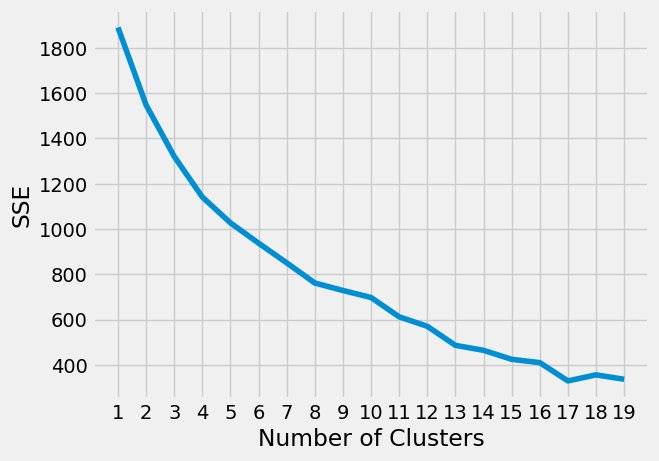

In [103]:
kmeans_kwargs = {
   "init": "random",
   "n_init": 100,
   "max_iter": 3000,
   "random_state": 42
   }

max_cluster = 20
# A list holds the SSE values for each k
sse = []
for k in range(1, max_cluster):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, max_cluster), sse)
plt.xticks(range(1, max_cluster))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Fit the model with desired number of clusters

In [108]:
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=42
    )

kmeans.fit(scaled_features)

df_features['label'] = kmeans.fit_predict(scaled_features)

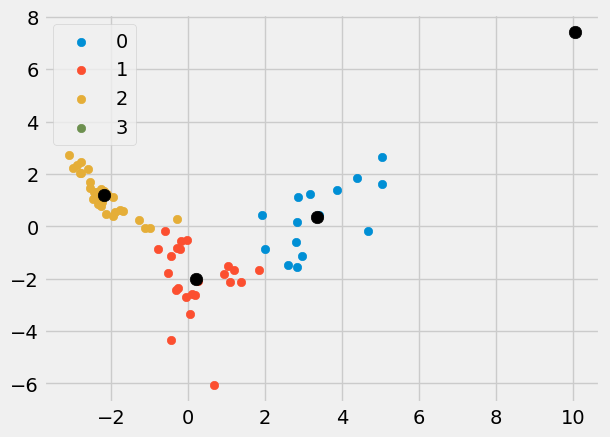

In [105]:
from sklearn.decomposition import PCA
pca = PCA(2)
 
#Transform the data
df_pca = pca.fit_transform(scaled_features)

#predict the labels of clusters.
label = kmeans.fit_predict(df_pca)

#Getting unique labels
u_labels = np.unique(label)
centroids = kmeans.cluster_centers_

#plotting the results:
for i in u_labels:
    plt.scatter(df_pca[label == i , 0] , df_pca[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [109]:
pd.set_option('display.max_columns', None)
df_features = df_features.apply(pd.to_numeric)

df_mean = df_features.groupby('label').mean()
df_count = df_features.groupby('label').size().reset_index(name='counts')

df_count.merge(df_mean, on = 'label', how = 'inner')

,label,counts,duration,SUM_DistanceWalkingRunning,AVG_RunningSpeed,SD_RunningSpeed,course_mean,course_std,HeartRate_mean,HeartRate_std,shareHR_90-100,shareHR_100-110,shareHR_110-120,shareHR_120-125,shareHR_125-130,shareHR_130-135,shareHR_135-140,shareHR_140-145,shareHR_145-150,shareHR_150-155,shareHR_155-160,shareHR_160-165,shareHR_165-170,shareHR_170-175,shareHR_175-180,shareHR_180-185,shareHR_185-190,shareHR_190-195,shareHR_195-200,shareHR_200-250
0,0,13,26.708118,4.295173,9.505371,0.818232,180.560100,96.209472,152.853893,10.932659,0.000740,0.007184,0.019806,0.003754,0.007167,0.008544,0.164838,0.041405,0.287301,0.149169,0.140271,0.083770,0.042761,0.006030,0.000000,0.036388,0.000000,0.000000,0.000000,0.0
1,1,11,84.451535,14.599449,8.403472,0.846209,178.794358,93.771484,140.598244,8.033904,0.002509,0.006595,0.010697,0.016031,0.061686,0.054076,0.275545,0.383074,0.148242,0.026914,0.005483,0.003944,0.001056,0.000913,0.001217,0.000000,0.000000,0.000000,0.000000,0.0
2,2,9,27.897355,4.426171,9.607421,2.313726,172.792977,98.767206,149.256879,19.853807,0.005698,0.026053,0.094394,0.040036,0.028964,0.049732,0.074231,0.078932,0.086795,0.084073,0.089038,0.074583,0.098924,0.091236,0.049333,0.010577,0.007054,0.003429,0.000449,0.0
3,3,37,32.558090,4.249850,7.938632,0.590562,177.139433,97.177036,127.016770,8.186969,0.012973,0.039520,0.161887,0.252774,0.248278,0.124161,0.079328,0.048582,0.020330,0.008682,0.001520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [110]:
df['label'] = kmeans.fit_predict(scaled_features)

In [113]:
df

,workout_pk,sourceName,workoutActivityType,duration,Date,SUM_ActiveEnergyBurned,SUM_BasalEnergyBurned,SUM_DistanceWalkingRunning,AVG_RunningGroundContactTime,AVG_RunningPower,AVG_RunningSpeed,AVG_RunningStrideLength,AVG_RunningVerticalOscillation,SD_RunningGroundContactTime,SD_RunningPower,SD_RunningSpeed,SD_RunningStrideLength,SD_RunningVerticalOscillation,ele_mean,ele_std,ele_p10,ele_p20,ele_p30,ele_p40,ele_p50,ele_p60,ele_p70,ele_p80,ele_p90,course_mean,course_std,course_p10,course_p20,course_p30,course_p40,course_p50,course_p60,course_p70,course_p80,course_p90,speed_mean,speed_std,speed_p10,speed_p20,speed_p30,speed_p40,speed_p50,speed_p60,speed_p70,speed_p80,speed_p90,hAcc_mean,hAcc_std,hAcc_p10,hAcc_p20,hAcc_p30,hAcc_p40,hAcc_p50,hAcc_p60,hAcc_p70,hAcc_p80,hAcc_p90,vAcc_mean,vAcc_std,vAcc_p10,vAcc_p20,vAcc_p30,vAcc_p40,vAcc_p50,vAcc_p60,vAcc_p70,vAcc_p80,vAcc_p90,HeartRate_mean,HeartRate_std,HeartRate_min,HeartRate_p10,HeartRate_p20,HeartRate_p30,HeartRate_p40,HeartRate_p50,HeartRate_p60,HeartRate_p70,HeartRate_p80,HeartRate_p90,HeartRate_max,HR_90-100,HR_100-110,HR_110-120,HR_120-125,HR_125-130,HR_130-135,HR_135-140,HR_140-145,HR_145-150,HR_150-155,HR_155-160,HR_160-165,HR_165-170,HR_170-175,HR_175-180,HR_180-185,HR_185-190,HR_190-195,HR_195-200,HR_200-250,duration_sec,shareHR_90-100,shareHR_100-110,shareHR_110-120,shareHR_120-125,shareHR_125-130,shareHR_130-135,shareHR_135-140,shareHR_140-145,shareHR_145-150,shareHR_150-155,shareHR_155-160,shareHR_160-165,shareHR_165-170,shareHR_170-175,shareHR_175-180,shareHR_180-185,shareHR_185-190,shareHR_190-195,shareHR_195-200,shareHR_200-250,label
29,380,Apple Watch von Lucas,Running,23.43646684885025,2023-04-03,211.876,57.970,3.512435,295.667333,212.507000,9.027170,0.916688,10.185083,7.444724,10.465897,0.252558,0.018701,0.238603,476.232389,8.972115,468.793914,469.812047,470.488479,471.115691,471.719056,472.536687,477.236596,484.444420,492.509689,181.206215,95.017321,69.953611,75.779140,94.778359,123.767925,140.034426,249.787156,257.072502,282.953858,305.427069,2.508582,0.199739,2.273766,2.366957,2.427292,2.482597,2.522435,2.562425,2.601073,2.650317,2.730116,1.605130,0.062995,1.576538,1.585162,1.589320,1.593127,1.596882,1.602457,1.607937,1.616970,1.630838,0.818016,0.036368,0.811704,0.814752,0.817760,0.819731,0.820542,0.821245,0.822328,0.823258,0.824870,149.321000,4.320422,146.266,146.8770,147.4880,148.0990,148.7100,149.3210,149.9320,150.5430,151.1540,151.7650,152.376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1403.0,422.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1825.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.768767,0.231233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
30,392,Apple Watch von Lucas,Running,24.51143266757329,2023-04-16,277.716,61.779,4.157219,281.366000,243.472200,10.161004,0.976969,10.150370,9.622784,16.560969,0.562359,0.035998,0.348987,455.058067,9.069499,444.996827,445.925781,446.588518,447.662933,453.884953,459.923224,461.970918,463.160823,469.055991,173.196600,103.663017,35.938130,55.239245,95.745928,135.705478,178.678561,219.703130,237.563571,272.916287,309.021027,2.814369,0.431427,2.344164,2.522898,2.691243,2.785446,2.859568,2.924639,3.004316,3.099761,3.278286,1.606966,0.089235,1.572902,1.581580,1.586607,1.593386,1.602157,1.615139,1.622761,1.630803,1.646532,0.821570,0.067107,0.809718,0.816235,0.819392,0.820582,0.821857,0.822935,0.823996,0.825062,0.826079,169.179000,18.881086,147.377,153.9168,160.4566,166.9964,173.5362,180.0760,180.0776,180.0792,180.0808,180.0824,180.084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1261.0,0.0,0.0,0.0,0.0,0.0,0.0,1132.0,0.0,0.0,0.0,0.0,2393.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.526954,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.473046,0.0,0.0,0.0,0.0,0
31,399,Apple Watch von Lucas,Running,22.21699406703313,2023-04-29,226.535,56.028,2.488721,293.295500,223.354000,8.976516,0.941737,9.868710,13.011472,25.526308,0.981306,0.002932,0.236725,488.6226

In [118]:
DimClusterRunning = df[['workout_pk', 'workoutActivityType', 'label']]

DimClusterRunning.to_parquet('./output_files/frontend_files/DimClusterRunning.parquet.gzip', compression='gzip')